In [119]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, roc_auc_score, RocCurveDisplay
)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from scipy import sparse
import os, json

In [120]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [139]:
from sklearn.datasets import load_svmlight_file

#ucitavanje podataka
X, y = load_svmlight_file("data/farm-ads-vect")
print(X.shape, y.shape)


(4143, 54877) (4143,)


In [122]:
#mapiranje {-1, 1}->{0, 1}
y = y.astype(int)
y = (y == 1).astype(int)

import pandas as pd
y = pd.Series(y)

print(y.value_counts())
print('y.mean: ', y.mean())

1    2210
0    1933
Name: count, dtype: int64
y.mean:  0.5334298817282163


In [123]:
#train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("X_train:", getattr(X_train, "shape", None), "X_test:", getattr(X_test, "shape", None))
print("Pos class share train:", y_train.mean(), " test:", y_test.mean())

X_train: (3314, 54877) X_test: (829, 54877)
Pos class share train: 0.5334942667471334  test: 0.5331724969843185


In [124]:
#cuvanje pocetnih podataka

out_dir = "artifacts_farm_ads"
os.makedirs(out_dir, exist_ok=True)

# cuvanje raw X as npz
if sparse.issparse(X):
    sparse.save_npz(os.path.join(out_dir, "X_raw.npz"), X.tocsr())
else:
    sparse.save_npz(os.path.join(out_dir, "X_raw.npz"), sparse.csr_matrix(X.values))

np.save(os.path.join(out_dir, "y_raw.npy"), np.array(y))

meta = {
    "random_state": RANDOM_STATE,
    "test_size": 0.2,
    "stratify": True,
    "target_mapping": {"-1": 0, "1": 1},
    "dataset": "UCI Farm Ads (id=218)"
}
with open(os.path.join(out_dir, "split_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:", out_dir)

Saved: artifacts_farm_ads


In [125]:
#preprocesiranje: TF-IDF

tfidf = TfidfTransformer()
Xtr_tfidf = tfidf.fit_transform(X_train)
Xte_tfidf = tfidf.transform(X_test)

print(Xtr_tfidf.shape, Xte_tfidf.shape)

sparse.save_npz(os.path.join(out_dir, "X_train_tfidf.npz"), Xtr_tfidf.tocsr())
sparse.save_npz(os.path.join(out_dir, "X_test_tfidf.npz"), Xte_tfidf.tocsr())
np.save(os.path.join(out_dir, "y_train.npy"), np.array(y_train))
np.save(os.path.join(out_dir, "y_test.npy"), np.array(y_test))

(3314, 54877) (829, 54877)


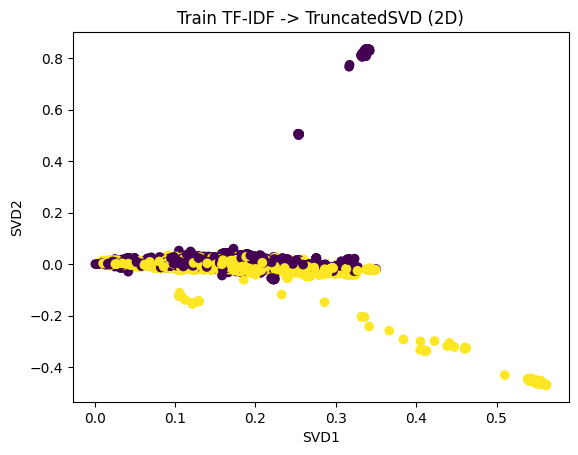

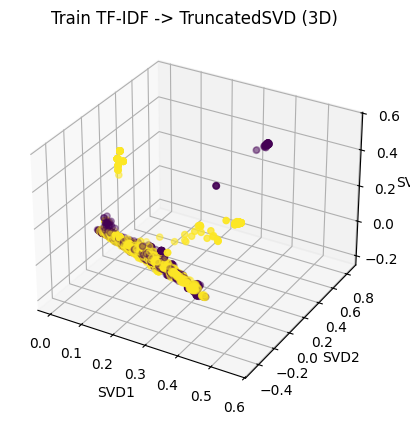

In [126]:
#vizuelizacija (2D i 3D) – TruncatedSVD na TF–IDF

def plot_svd_scatter(X_sparse, y, n_components=2, title="SVD scatter"):
    svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    X_low = svd.fit_transform(X_sparse)

    if n_components == 2:
        plt.figure()
        plt.scatter(X_low[:,0], X_low[:,1], c=y)
        plt.xlabel("SVD1"); plt.ylabel("SVD2")
        plt.title(title + " (2D)")
        plt.show()
    else:
        from mpl_toolkits.mplot3d import Axes3D  # noqa
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(X_low[:,0], X_low[:,1], X_low[:,2], c=y)
        ax.set_xlabel("SVD1"); ax.set_ylabel("SVD2"); ax.set_zlabel("SVD3")
        ax.set_title(title + " (3D)")
        plt.show()

plot_svd_scatter(Xtr_tfidf, y_train, n_components=2, title="Train TF-IDF -> TruncatedSVD")
plot_svd_scatter(Xtr_tfidf, y_train, n_components=3, title="Train TF-IDF -> TruncatedSVD")

In [127]:
#Chi2 
K_CHI2 = 20000
chi2_sel = SelectKBest(chi2, k=K_CHI2)
Xtr_chi2 = chi2_sel.fit_transform(Xtr_tfidf, y_train)
Xte_chi2 = chi2_sel.transform(Xte_tfidf)
print("CHI2:", Xtr_chi2.shape, Xte_chi2.shape)

# SVD
N_SVD = 300
svd_red = TruncatedSVD(n_components=N_SVD, random_state=RANDOM_STATE)
Xtr_svd = svd_red.fit_transform(Xtr_tfidf)
Xte_svd = svd_red.transform(Xte_tfidf)
print("SVD:", Xtr_svd.shape, Xte_svd.shape)

sparse.save_npz(os.path.join(out_dir, f"X_train_chi2_{K_CHI2}.npz"), Xtr_chi2.tocsr())
sparse.save_npz(os.path.join(out_dir, f"X_test_chi2_{K_CHI2}.npz"), Xte_chi2.tocsr())
np.save(os.path.join(out_dir, f"X_train_svd_{N_SVD}.npy"), Xtr_svd)
np.save(os.path.join(out_dir, f"X_test_svd_{N_SVD}.npy"), Xte_svd)

with open(os.path.join(out_dir, "reduction_meta.json"), "w", encoding="utf-8") as f:
    json.dump({"chi2_k": K_CHI2, "svd_components": N_SVD}, f, ensure_ascii=False, indent=2)

CHI2: (3314, 20000) (829, 20000)
SVD: (3314, 300) (829, 300)


In [129]:
#pravljenje modela
models = {
    "MultinomialNB": MultinomialNB(alpha=1.0),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "LinearSVC": LinearSVC(),
    "DecisionTree": DecisionTreeClassifier(max_depth=50, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=50,
        max_depth=50,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
}

In [130]:
#evaluacija funkcije

def fit_predict_scores(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    score_test = None
    if hasattr(model, "decision_function"):
        score_test = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        score_test = model.predict_proba(X_test)[:, 1]
    return model, yhat_train, yhat_test, score_test

def evaluate_to_row(name, model, X_train, y_train, X_test, y_test):
    model, yhat_train, yhat_test, score_test = fit_predict_scores(model, X_train, y_train, X_test)

    rep_train = classification_report(y_train, yhat_train, output_dict=True)
    rep_test = classification_report(y_test, yhat_test, output_dict=True)

    row = {
        "model": name,
        "acc_train": accuracy_score(y_train, yhat_train),
        "acc_test": accuracy_score(y_test, yhat_test),
        "precision_train": rep_train["weighted avg"]["precision"],
        "precision_test": rep_test["weighted avg"]["precision"],
        "recall_train": rep_train["weighted avg"]["recall"],
        "recall_test": rep_test["weighted avg"]["recall"],
        "f1_train": rep_train["weighted avg"]["f1-score"],
        "f1_test": rep_test["weighted avg"]["f1-score"],
        "roc_auc_test": np.nan,
    }

    if score_test is not None:
        row["roc_auc_test"] = roc_auc_score(y_test, score_test)

    return row

def show_confusion_and_roc(title, model, X_test, y_test):
    yhat = model.predict(X_test)
    cm = confusion_matrix(y_test, yhat)
    ConfusionMatrixDisplay(cm, display_labels=["rejected(0)", "accepted(1)"]).plot(values_format="d")
    plt.title(f"{title} – Confusion matrix (TEST)")
    plt.show()

    score_test = None
    if hasattr(model, "decision_function"):
        score_test = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        score_test = model.predict_proba(X_test)[:, 1]

    if score_test is not None:
        RocCurveDisplay.from_predictions(y_test, score_test)
        plt.title(f"{title} – ROC curve (TEST)")
        plt.show()
        print("ROC-AUC (TEST):", roc_auc_score(y_test, score_test))

In [131]:
#full atributi: TF-IDF
rows_full, fitted_full = [], {}

for name, mdl in models.items():
    try:
        rows_full.append(evaluate_to_row(name, mdl, Xtr_tfidf, y_train, Xte_tfidf, y_test))
        mdl.fit(Xtr_tfidf, y_train)
        fitted_full[name] = mdl
    except Exception as e:
        print(f"[FULL] Preskačem {name} zbog greške: {e}")

df_full = pd.DataFrame(rows_full).sort_values("f1_test", ascending=False)
df_full

,model,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc_test
2,LinearSVC,0.993965,0.901086,0.993981,0.903009,0.993965,0.901086,0.993964,0.900680,0.972845
1,LogisticRegression,0.960471,0.895054,0.961403,0.900841,0.960471,0.895054,0.960384,0.894165,0.968185
4,RandomForest,0.982498,0.868516,0.983015,0.877185,0.982498,0.868516,0.982474,0.866918,0.958042
0,MultinomialNB,0.923657,0.866104,0.927160,0.875876,0.923657,0.866104,0.923230,0.864320,0.954927
3,DecisionTree,0.973144,0.858866,0.974201,0.860940,0.973144,0.858866,0.973084,0.858158,0.859331


Najbolji (FULL TF-IDF): LinearSVC


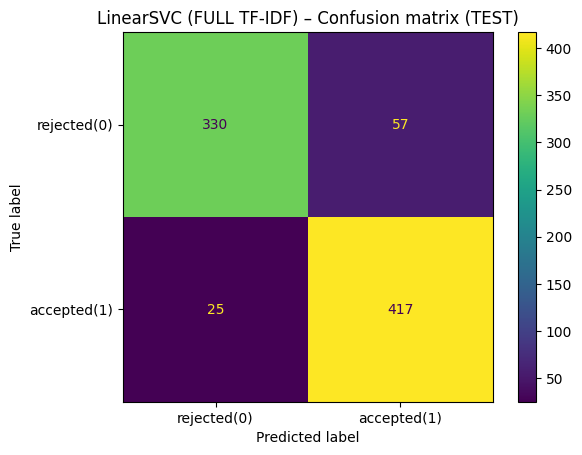

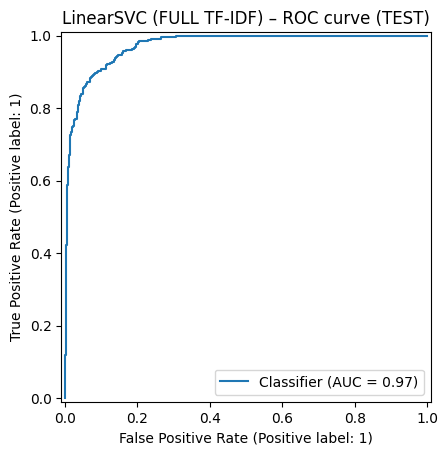

ROC-AUC (TEST): 0.9728448326259542


In [132]:
best_name = df_full.iloc[0]["model"]
print("Najbolji (FULL TF-IDF):", best_name)
show_confusion_and_roc(f"{best_name} (FULL TF-IDF)", fitted_full[best_name], Xte_tfidf, y_test)

In [133]:
#redukovani atributi chi2
rows_chi2, fitted_chi2 = [], {}

for name, mdl in models.items():
    try:
        rows_chi2.append(evaluate_to_row(name, mdl, Xtr_chi2, y_train, Xte_chi2, y_test))
        mdl.fit(Xtr_chi2, y_train)
        fitted_chi2[name] = mdl
    except Exception as e:
        print(f"[CHI2] Preskačem {name} zbog greške: {e}")

df_chi2 = pd.DataFrame(rows_chi2).sort_values("f1_test", ascending=False)
df_chi2

,model,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc_test
2,LinearSVC,0.990042,0.904704,0.990113,0.907431,0.990042,0.904704,0.990038,0.904227,0.972810
1,LogisticRegression,0.945987,0.886610,0.947447,0.891072,0.945987,0.886610,0.945825,0.885782,0.966432
4,RandomForest,0.981291,0.880579,0.981883,0.886461,0.981291,0.880579,0.981262,0.879509,0.961571
0,MultinomialNB,0.917622,0.866104,0.920753,0.874679,0.917622,0.866104,0.917186,0.864476,0.955704
3,DecisionTree,0.969523,0.860072,0.970909,0.861771,0.969523,0.860072,0.969441,0.859449,0.870070


Najbolji (CHI2 top-20000): LinearSVC


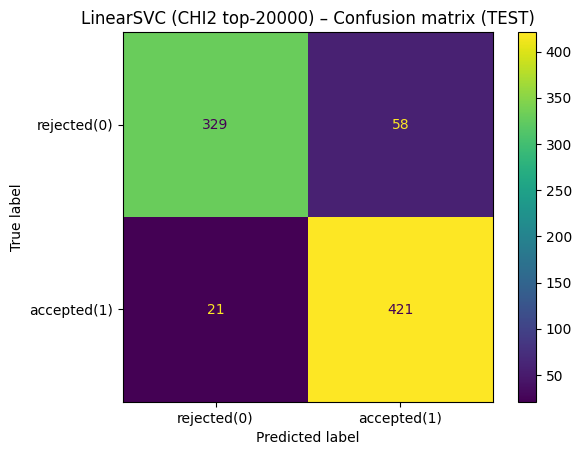

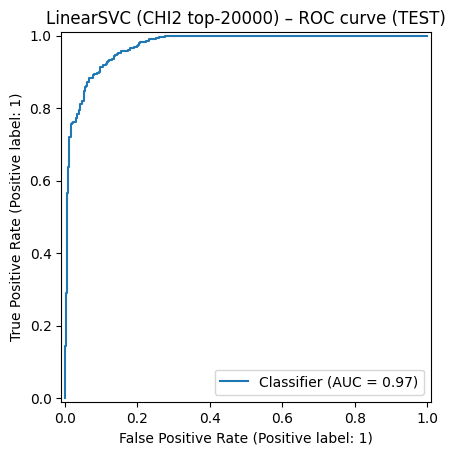

ROC-AUC (TEST): 0.9728097559834906


In [134]:
best_name = df_chi2.iloc[0]["model"]
print(f"Najbolji (CHI2 top-{K_CHI2}):", best_name)
show_confusion_and_roc(f"{best_name} (CHI2 top-{K_CHI2})", fitted_chi2[best_name], Xte_chi2, y_test)

In [135]:
#redukovani atributi: SVD
rows_svd, fitted_svd = [], {}

for name, mdl in models.items():
    if name == "MultinomialNB":
        print("[SVD] Preskačem MultinomialNB (SVD ima negativne vrednosti).")
        continue

    try:
        rows_svd.append(evaluate_to_row(name, mdl, Xtr_svd, y_train, Xte_svd, y_test))
        mdl.fit(Xtr_svd, y_train)
        fitted_svd[name] = mdl
    except Exception as e:
        print(f"[SVD] Preskačem {name} zbog greške: {e}")

df_svd = pd.DataFrame(rows_svd).sort_values("f1_test", ascending=False)
df_svd

[SVD] Preskačem MultinomialNB (SVD ima negativne vrednosti).


,model,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc_test
1,LinearSVC,0.925769,0.895054,0.926532,0.898320,0.925769,0.895054,0.925605,0.894445,0.964666
0,LogisticRegression,0.910682,0.886610,0.913493,0.891499,0.910682,0.886610,0.910231,0.885730,0.960515
3,RandomForest,0.998793,0.880579,0.998794,0.885992,0.998793,0.880579,0.998793,0.879567,0.959802
2,DecisionTree,0.998793,0.832328,0.998793,0.833376,0.998793,0.832328,0.998793,0.831671,0.828846


Najbolji (SVD 300): LinearSVC


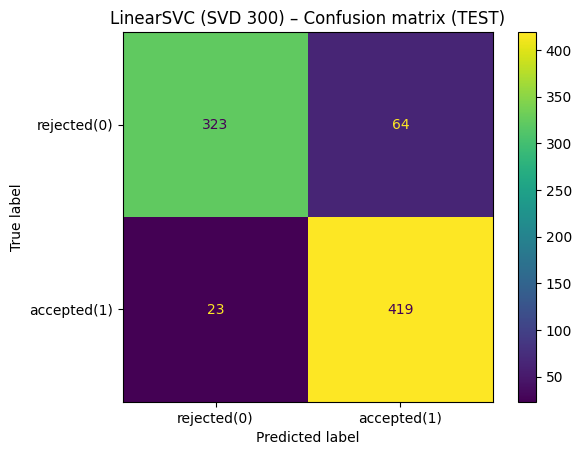

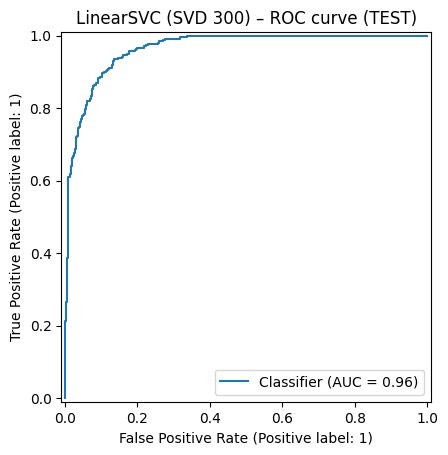

ROC-AUC (TEST): 0.9646661288248156


In [136]:
best_name = df_svd.iloc[0]["model"]
print(f"Najbolji (SVD {N_SVD}):", best_name)
show_confusion_and_roc(f"{best_name} (SVD {N_SVD})", fitted_svd[best_name], Xte_svd, y_test)

In [137]:
#konacno poredjenje i cuvanje rezultata

df_full["feature_set"] = "FULL TF-IDF"
df_chi2["feature_set"] = f"CHI2 top-{K_CHI2}"
df_svd["feature_set"] = f"SVD {N_SVD}"

df_all = pd.concat([df_full, df_chi2, df_svd], ignore_index=True)
df_all = df_all.sort_values(["feature_set","f1_test"], ascending=[True, False])
df_all

,model,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc_test,feature_set
5,LinearSVC,0.990042,0.904704,0.990113,0.907431,0.990042,0.904704,0.990038,0.904227,0.972810,CHI2 top-20000
6,LogisticRegression,0.945987,0.886610,0.947447,0.891072,0.945987,0.886610,0.945825,0.885782,0.966432,CHI2 top-20000
7,RandomForest,0.981291,0.880579,0.981883,0.886461,0.981291,0.880579,0.981262,0.879509,0.961571,CHI2 top-20000
8,MultinomialNB,0.917622,0.866104,0.920753,0.874679,0.917622,0.866104,0.917186,0.864476,0.955704,CHI2 top-20000
9,DecisionTree,0.969523,0.860072,0.970909,0.861771,0.969523,0.860072,0.969441,0.859449,0.870070,CHI2 top-20000
0,LinearSVC,0.993965,0.901086,0.993981,0.903009,0.993965,0.901086,0.993964,0.900680,0.972845,FULL TF-IDF
1,LogisticRegression,0.960471,0.895054,0.961403,0.900841,0.960471,0.895054,0.960384,0.894165,0.968185,FULL TF-IDF
2,RandomForest,0.982498,0.868516,0.983015,0.877185,0.982498,0.868516,0.982474,0.866918,0.958042,FULL TF-IDF
3,MultinomialNB,0.923657,0.866104,0.927160,0.875876,0.923657,0.866104,0.923230,0.864320,0.954927,FULL TF-IDF
4,DecisionTree,0.973144,0.858866,0.974201,0.860940,0.973144,0.858866,0.973084,0.858158,0.859331,FULL TF-IDF


In [138]:
df_all.to_csv(os.path.join(out_dir, "results_summary.csv"), index=False)
print("Saved:", os.path.join(out_dir, "results_summary.csv"))

Saved: artifacts_farm_ads/results_summary.csv
